## Assignment 2: $k$ Nearest Neighbor

### Do any four.

**Q1.** Please answer the following questions.
1. What is the difference between regression and classification?
2. What is a confusion table/matrix? What does it help us understand about a model's performance?
3. What is Accuracy? Why might it not be entirely sufficient to evaluate a classifer's predictive performance?
4. What does the root mean squared error quantify about a particular model?
5. What are overfitting and underfitting?
6. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or RMSE on the test set, improve model performance?
7. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.



1. The difference between regression and classification is that regression predicts a continuous numerical outcome, while classification predicts a discrete category or label. In regression, the output could be something like house price, stock returns, or temperature. In classification, the output is a category such as spam vs. not spam or default vs. no default. The key distinction is whether the response variable is continuous or categorical.

2. A confusion matrix is a table used to evaluate the performance of a classification model by comparing predicted labels with actual labels. In binary classification, it includes true positives, true negatives, false positives, and false negatives. It helps us understand not just how many predictions were correct, but what types of mistakes the model is making. From the confusion matrix, we can calculate metrics such as precision, recall, and F1-score, which provide deeper insight than accuracy alone.

3. Accuracy is the proportion of correct predictions out of all predictions made. It is calculated as (true positives + true negatives) divided by the total number of observations. However, accuracy may not be sufficient when dealing with imbalanced datasets. For example, if 95% of cases belong to one class, a model that predicts that class every time would have 95% accuracy but would not be useful. Therefore, accuracy does not always reflect how well the model performs across different classes.

4. Root Mean Squared Error (RMSE) measures the average magnitude of the prediction error in a regression model. It is the square root of the average squared difference between actual values and predicted values. RMSE tells us how far, on average, our predictions are from the true values. Because the errors are squared before averaging, larger errors are penalized more heavily. A lower RMSE indicates better model performance.

5. Overfitting occurs when a model is too complex and captures noise in the training data rather than the true underlying pattern. This results in very low training error but poor performance on new data. Underfitting happens when a model is too simple to capture the underlying relationship in the data, leading to poor performance on both training and test data. The goal is to find a balance where the model generalizes well to unseen data.

6. Splitting the data into training and testing sets allows us to evaluate how well the model performs on unseen data. The training set is used to fit the model, while the test set is used to assess its generalization performance. When choosing a parameter like k in k-nearest neighbors, evaluating performance on the test set helps prevent overfitting and ensures we select the model complexity that performs best out-of-sample. This improves the reliability of the model’s performance.

7. In classification, we can report either a predicted class label or a probability distribution over class labels. Reporting just a class label is simple and easy to interpret because it gives a direct decision. However, it does not show how confident the model is in that decision. Reporting probabilities provides more information about the model’s confidence and allows for flexible decision thresholds, which can be especially useful in risk-sensitive applications. The downside is that probabilities can be harder to interpret and require proper calibration to be meaningful.

In [20]:
import urllib.request
import os
import zipfile
import os

def download_data(force=False):
    """Download and extract course data from Zenodo."""

    zip_path = 'data.zip'
    data_dir = './data'

    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/18235955/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")

    if not os.path.exists(data_dir) or force:
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")

    return data_dir


if __name__ == "__main__":
    download_data()

**Q2.** This is a case study on $k$ nearest neighbor classification, using the `land_mines.csv` data.

The data consists of a label, `mine_type`, taking integer values 1 to 5, and three properties of the mine, `voltage`, `height` and `soil`. We want to predict the kind of mine from data about it. Imagine working for the DOD or a humanitarian aid agency, trying to help people remove land mines more safely.

1. Load the data. Perform some EDA, summarizing the target label and the relationships between the features (e.g. scatterplots, describe tables).
2. Split the sample 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion table for your best model, comparing predicted and actual class label on the test set. How accurate is it? Where is performance more or less accurate?
5. Notice that you can have a lot of accurate predictions for a given type of mine, but still make a lot of mistakes. Please explain how you'd advise someone to actually use this predictive model in practice, given the errors that it tends to make.

Q2.1

In [3]:
import pandas as pd

df = pd.read_csv("./data/land_mines.csv")
df.head()

,voltage,height,soil,mine_type
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voltage    338 non-null    float64
 1   height     338 non-null    float64
 2   soil       338 non-null    float64
 3   mine_type  338 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 10.7 KB


,voltage,height,soil,mine_type
count,338.000000,338.000000,338.000000,338.000000
mean,0.430634,0.508876,0.503550,2.952663
std,0.195819,0.306043,0.344244,1.419703
min,0.197734,0.000000,0.000000,1.000000
25%,0.309737,0.272727,0.200000,2.000000
50%,0.359516,0.545455,0.600000,3.000000
75%,0.482628,0.727273,0.800000,4.000000
max,0.999999,1.000000,1.000000,5.000000


In [7]:
df["mine_type"].value_counts().sort_index()
df["mine_type"].value_counts(normalize=True)

,proportion
mine_type,
1,0.210059
2,0.207101
3,0.195266
4,0.195266
5,0.192308


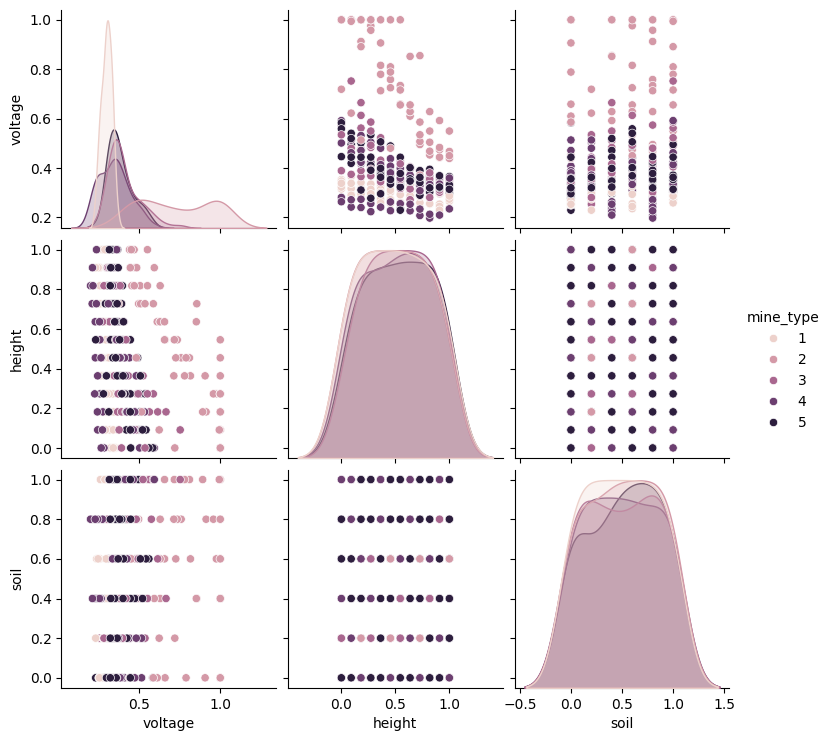

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, hue="mine_type")
plt.show()

Q2.2

In [9]:
from sklearn.model_selection import train_test_split

X = df[["voltage", "height", "soil"]]
y = df["mine_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,
    stratify=y,
    random_state=42
)

Q2.3 - The training accuracy is highest at k = 1 (nearly 100%), but this reflects overfitting, since the model memorizes the training data. However, the test accuracy at k = 1 is only about 51%, indicating poor generalization. As k increases, training accuracy declines steadily, while test accuracy stabilizes around 40–43%. This suggests that small k values result in high variance, while large k values result in higher bias.

Although k = 1 yields the highest test accuracy, the large gap between training and test performance indicates overfitting. Therefore, I would select a slightly larger k that balances bias and variance, even if it slightly reduces test accuracy. Overall, the relatively low maximum test accuracy suggests that the three features (voltage, height, and soil) may not provide strong separation between mine types.

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_acc = []
test_acc = []

k_values = range(1, 26)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    train_acc.append(accuracy_score(y_train, knn.predict(X_train_scaled)))
    test_acc.append(accuracy_score(y_test, knn.predict(X_test_scaled)))

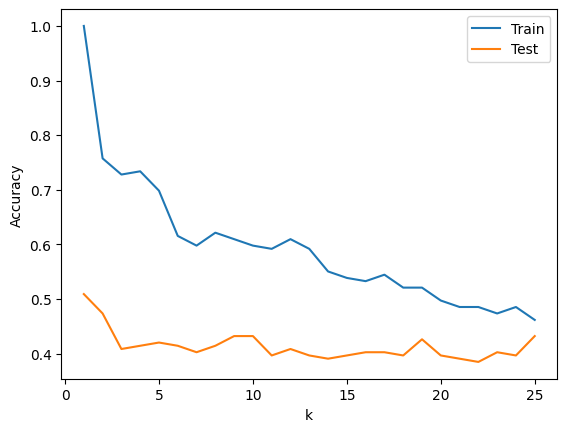

In [12]:
plt.plot(k_values, train_acc, label="Train")
plt.plot(k_values, test_acc, label="Test")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Q2.4 - The overall test accuracy is approximately 51%, which is substantially better than random guessing (20% for five classes), but still indicates considerable classification error. The confusion matrix shows that performance varies across mine types. Class 1 is classified very accurately, with 32 correct predictions and very few misclassifications. In contrast, classes 2 and 4 are frequently confused with each other, suggesting that their feature values overlap in the voltage, height, and soil dimensions. Class 3 is also moderately dispersed across predicted categories.

These results indicate that while the model performs well for some mine types, it struggles to separate others. In practice, this model should not be used as an automated decision system for mine removal. Instead, it should be used as a decision-support tool, potentially flagging high-uncertainty predictions for expert review. Additionally, if certain mine types pose greater risk, the model should be tuned to minimize false negatives for those categories rather than optimizing overall accuracy.

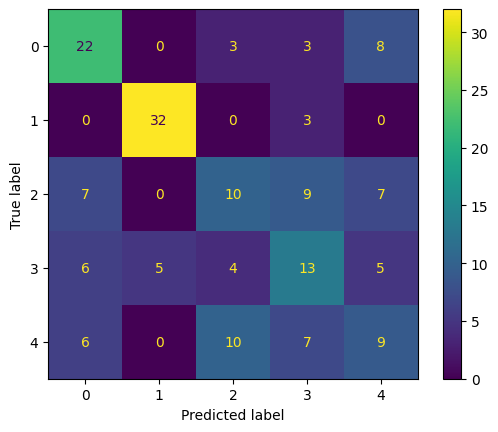

0.5088757396449705

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_k = k_values[test_acc.index(max(test_acc))]

knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)

y_pred = knn_best.predict(X_test_scaled)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

accuracy_score(y_test, y_pred)

**Q3.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for hyper-parameter selection and evaluation.
4. Use the $k$-NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

Q3.1

In [14]:
import pandas as pd

df = pd.read_csv("./data/USA_cars_datasets.csv")
df = df[["price", "year", "mileage"]]  # Keep only required variables

df.head()
df.shape
df.isna().sum()

,0
price,0
year,0
mileage,0


Q3.2

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[["year", "mileage"]] = scaler.fit_transform(df[["year", "mileage"]])

Q3.3

In [16]:
from sklearn.model_selection import train_test_split

X = df[["year", "mileage"]]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

Q3.4 - As k increases, the model’s predictions become smoother and less sensitive to local fluctuations in the data. For small values of k (such as k = 3), the model is highly flexible and reacts strongly to nearby observations, which leads to high variance and potential overfitting. This is visible in the scatterplots as greater dispersion in predicted prices.

As k increases to moderate values (around 25 to 50), the predictions stabilize and align more closely with the overall upward trend between actual and predicted prices. The mean squared error decreases and reaches its minimum in this range, indicating a better balance between bias and variance.

When k becomes large (such as 100 or 300), the model begins to underfit. Predictions shrink toward the overall mean price, causing expensive cars to be underpredicted and inexpensive cars to be overpredicted. In the scatterplots, this appears as a vertical compression of the points. Overall, increasing k reduces variance but increases bias, illustrating the classic bias–variance tradeoff in k-NN regression.

k = 3, MSE = 148065935.51955554


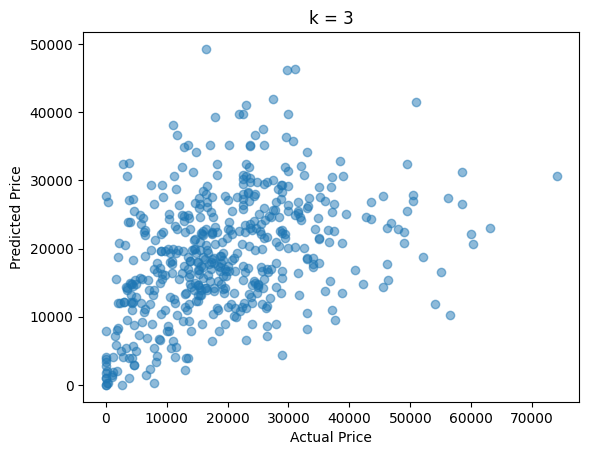

k = 10, MSE = 117399126.10604002


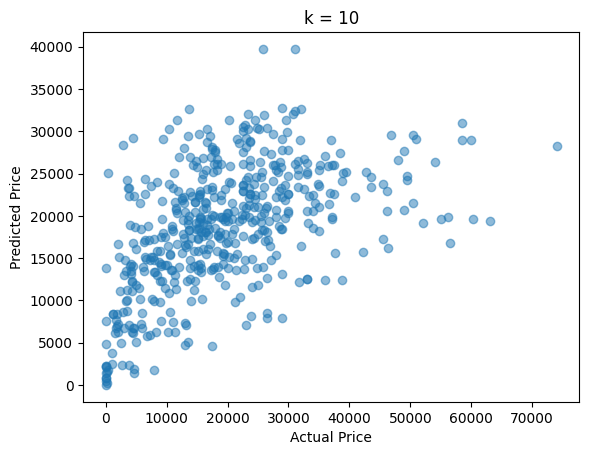

k = 25, MSE = 112576160.82390079


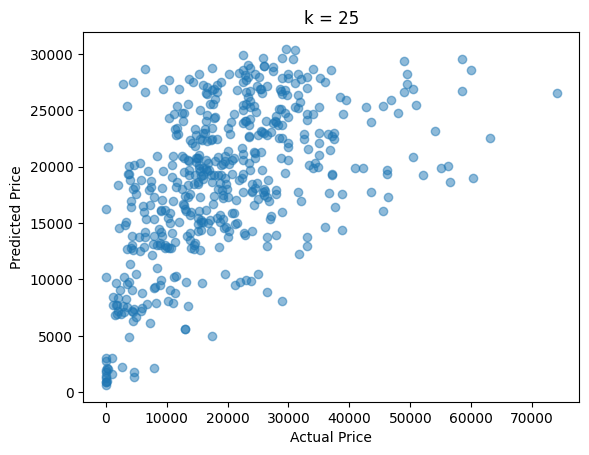

k = 50, MSE = 110202549.3014296


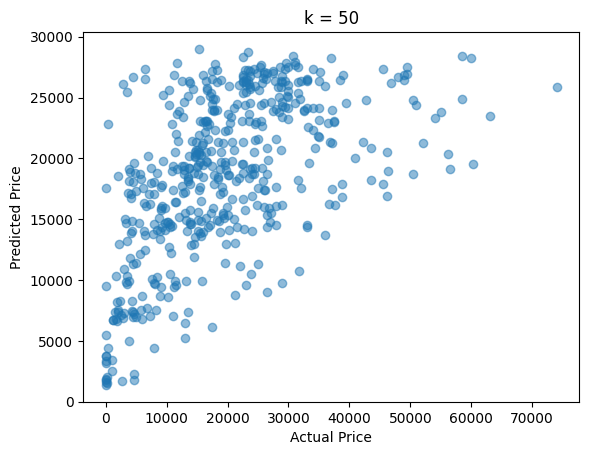

k = 100, MSE = 112253702.9700672


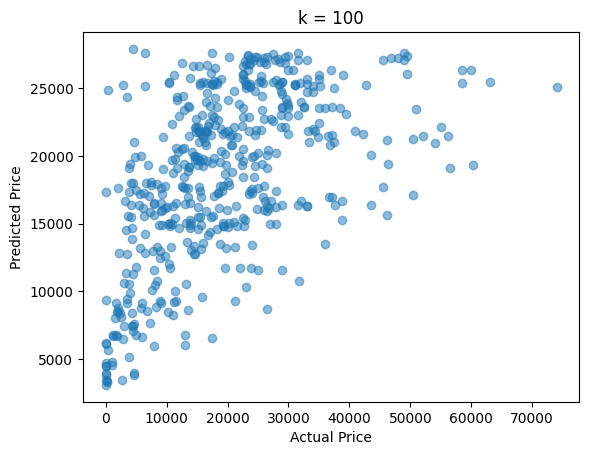

k = 300, MSE = 114496092.28682345


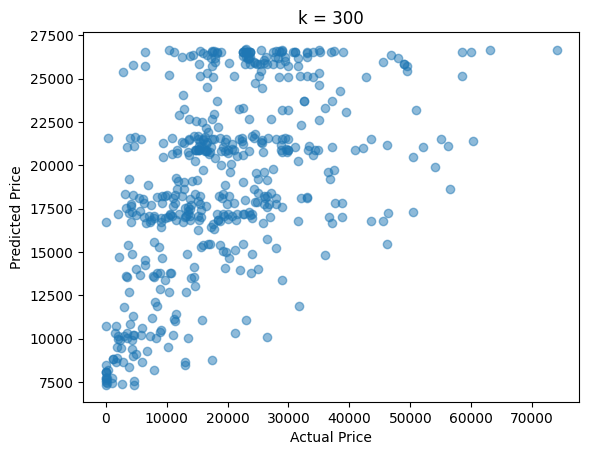

In [18]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

k_values = [3, 10, 25, 50, 100, 300]
mse_values = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

    print(f"k = {k}, MSE = {mse}")

    # Scatterplot predicted vs actual
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"k = {k}")
    plt.show()

Q3.5 - To determine the optimal k, I compared the mean squared error (MSE) on the test set for each value of k = 3, 10, 25, 50, 100, and 300. The MSE values steadily decreased as k increased from 3 to 50, reaching their minimum at k = 50. After k = 50, the MSE began to increase again for larger values of k (100 and 300).

Since k = 50 produces the lowest test MSE, it is the optimal value for these data. At this point, the model achieves the best balance between bias and variance. Smaller values of k tend to overfit the data by capturing too much local noise, while larger values of k begin to underfit by averaging over too many observations and shrinking predictions toward the overall mean price.

Q3.6 - As k varied, the predicted-versus-actual scatterplots changed in a way that reflects the tradeoff between overfitting and underfitting. With small k (e.g., k = 3), the k-NN regressor is very flexible and heavily influenced by a few nearby points, so predictions fluctuate a lot across observations. This high-variance behavior leads to overfitting, which shows up as a more scattered and noisy cloud of points and a higher test MSE.

As k increases to moderate values (around k = 25 to 50), predictions become smoother and more stable because each prediction averages over more neighbors. In this range, the points align more consistently with the overall upward relationship between actual and predicted prices, and the test MSE reaches its minimum (optimal performance).

For large k (e.g., k = 100 or 300), the model averages over many neighbors and becomes overly smooth. Predictions shrink toward the overall mean price, which causes expensive cars to be underpredicted and cheap cars to be overpredicted. This high-bias behavior is underfitting, and it is visible in the plots as vertical compression of predicted values and a rising test MSE.

**Q4.** This question is a case study for $k$ nearest neighbor regression, using the `heart_failure_clinical_records_dataset.csv` data.

The data for the question include:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$-NN classification or regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has the best Mean Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the RMSE change for your fitted model on the test data? Are more variables always better? Explain your findings.

**Q5.** This is a case study on $k$ nearest neighbor classification, using the `animals.csv` data.

The data consist of a label, `class`, taking integer values 1 to 7, the name of the species, `animal`, and 16 characteristics of the animal, including `hair`, `feathers`, `milk`, `eggs`, `airborne`, and so on.

1. Load the data. For each of the seven class labels, print the values in the class and get a sense of what is included in that group. Perform some other EDA: How big are the classes? How much variation is there in each of the features/covariates? Which variables do you think will best predict which class?
2. Split the data 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be. Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Using all of the variables, build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion matrix for the optimal model, comparing predicted and actual class label on the test set. How accurate it is? Can you interpret why mistakes are made across groups?
5. Use only `milk`, `aquatic`, and `airborne` to train a new $k$-NN classifier. Print your confusion table. Mine does not predict all of the classes, only a subset of them. To see the underlying proportions/probabilities, use `model.predict_proba(X_test.values)` to predict probabilities rather than labels for your `X_test` test data for your fitted `model`. Are all of the classes represented? Explain your results.

Q5.1

In [26]:
import pandas as pd

df = pd.read_csv("./data/zoo.csv")

df.head()
df.shape
df["class"].value_counts().sort_index()

,count
class,
1,41
2,20
3,5
4,13
5,4
6,8
7,10


In [27]:
# class sizes
df["class"].value_counts().sort_index()

,count
class,
1,41
2,20
3,5
4,13
5,4
6,8
7,10


In [28]:
# print the animals in each class to see what's in each group
name_col = "animal" if "animal" in df.columns else "animal_name"

for c in sorted(df["class"].unique()):
    animals_in_class = df.loc[df["class"] == c, name_col].tolist()
    print(f"\nClass {c} (n={len(animals_in_class)}):")
    print(animals_in_class)


Class 1 (n=41):
['aardvark', 'antelope', 'bear', 'boar', 'buffalo', 'calf', 'cavy', 'cheetah', 'deer', 'dolphin', 'elephant', 'fruitbat', 'giraffe', 'girl', 'goat', 'gorilla', 'hamster', 'hare', 'leopard', 'lion', 'lynx', 'mink', 'mole', 'mongoose', 'opossum', 'oryx', 'platypus', 'polecat', 'pony', 'porpoise', 'puma', 'pussycat', 'raccoon', 'reindeer', 'seal', 'sealion', 'squirrel', 'vampire', 'vole', 'wallaby', 'wolf']

Class 2 (n=20):
['chicken', 'crow', 'dove', 'duck', 'flamingo', 'gull', 'hawk', 'kiwi', 'lark', 'ostrich', 'parakeet', 'penguin', 'pheasant', 'rhea', 'skimmer', 'skua', 'sparrow', 'swan', 'vulture', 'wren']

Class 3 (n=5):
['pitviper', 'seasnake', 'slowworm', 'tortoise', 'tuatara']

Class 4 (n=13):
['bass', 'carp', 'catfish', 'chub', 'dogfish', 'haddock', 'herring', 'pike', 'piranha', 'seahorse', 'sole', 'stingray', 'tuna']

Class 5 (n=4):
['frog', 'frog', 'newt', 'toad']

Class 6 (n=8):
['flea', 'gnat', 'honeybee', 'housefly', 'ladybird', 'moth', 'termite', 'wasp']



In [29]:
# feature variation (how many unique values each feature takes)
# (drop class + name column)
X = df.drop(columns=["class", name_col])

X.nunique().sort_values()

,0
hair,2
feathers,2
eggs,2
milk,2
airborne,2
aquatic,2
predator,2
toothed,2
backbone,2
breathes,2


In [30]:

X.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000


Q5.2 - The data were split 50/50 into training and test sets. Because the dataset is relatively small, an equal split helps ensure that enough observations remain in each group for both training and evaluation.

Stratification was used when splitting the data. This ensures that the proportion of animals in each of the seven classes remains similar in both the training and test sets. Without stratification, it is possible that some classes would be underrepresented or completely missing from one of the splits, which would make the k-NN classifier unstable or unable to predict certain categories.

In [31]:
from sklearn.model_selection import train_test_split

# Identify name column correctly
name_col = "animal" if "animal" in df.columns else "animal_name"

X = df.drop(columns=["class", name_col])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,
    stratify=y,      # VERY important for small data
    random_state=42
)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTraining class distribution:")
print(y_train.value_counts().sort_index())

print("\nTest class distribution:")
print(y_test.value_counts().sort_index())

Training shape: (50, 16)
Test shape: (51, 16)

Training class distribution:
class
1    20
2    10
3     3
4     6
5     2
6     4
7     5
Name: count, dtype: int64

Test class distribution:
class
1    21
2    10
3     2
4     7
5     2
6     4
7     5
Name: count, dtype: int64


Q5.3 - To select the optimal value of k, I evaluated test accuracy for k values from 1 to 20. The highest test accuracy (approximately 96.1%) occurred at k = 1.

This suggests that the dataset is highly separable in feature space when using all 16 characteristics. With k = 1, the classifier relies on the nearest neighbor and performs extremely well, indicating that animals from the same biological class share very similar feature patterns and are well separated from other classes.

Although k = 1 can sometimes lead to overfitting due to high variance, the high test accuracy suggests that overfitting is minimal in this dataset. As k increases, accuracy steadily decreases because the model begins averaging across neighbors from different classes, introducing bias and reducing classification precision.

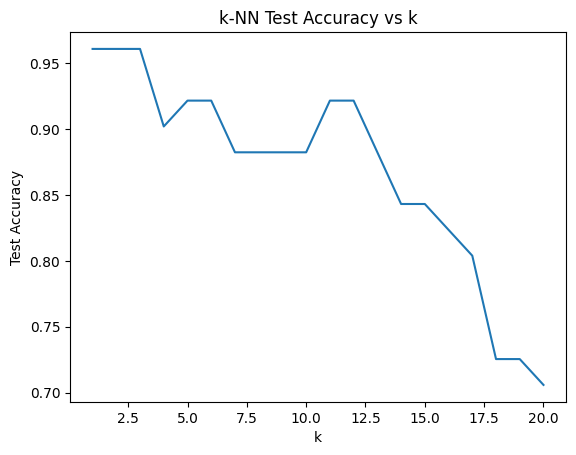

Best k: 1
Best Test Accuracy: 0.9607843137254902


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Scale features (important for kNN distance calculations)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Try multiple k values
k_values = range(1, 21)
test_accuracy = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_s, y_train)
    preds = model.predict(X_test_s)
    test_accuracy.append(accuracy_score(y_test, preds))

# Plot accuracy vs k
plt.plot(k_values, test_accuracy)
plt.xlabel("k")
plt.ylabel("Test Accuracy")
plt.title("k-NN Test Accuracy vs k")
plt.show()

# Select best k
best_k = k_values[test_accuracy.index(max(test_accuracy))]
print("Best k:", best_k)
print("Best Test Accuracy:", max(test_accuracy))

Q5.4 - Using the optimal model with k = 1, the confusion matrix shows extremely strong classification performance, with a test accuracy of approximately 96.1%. Most classes are perfectly classified, and the matrix is nearly entirely diagonal.

Class 1 (21 observations), class 2 (10 observations), class 4 (7 observations), class 6 (4 observations), and class 7 (5 observations) are classified with 100% accuracy. Only two errors occur in the entire test set, both involving confusion between class 3 and nearby biological groups. Specifically, one instance of class 3 is predicted as class 4, and one instance of class 5 is predicted as class 3.

These mistakes likely occur because those classes share overlapping biological characteristics. For example, reptiles and amphibians share traits such as laying eggs and having similar structural features, making them closer in feature space. However, strongly defining traits such as milk (mammals) and feathers (birds) produce clear separation for other groups.

Overall, the confusion matrix confirms that the 16 available biological features provide strong separation between animal classes, allowing k-NN with k = 1 to perform extremely well.

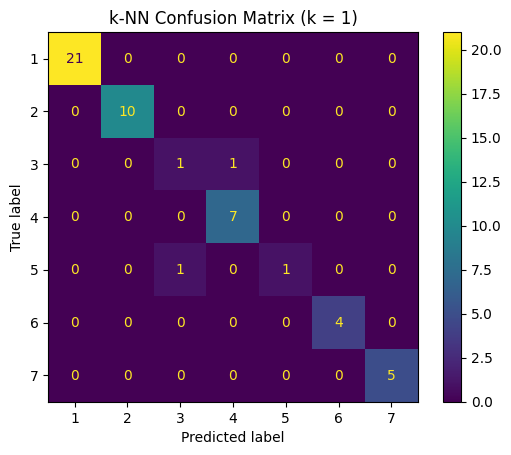

Test Accuracy: 0.9607843137254902


In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Train optimal model
best_model = KNeighborsClassifier(n_neighbors=best_k)
best_model.fit(X_train_s, y_train)

# Predictions
y_pred = best_model.predict(X_test_s)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))

ConfusionMatrixDisplay(cm, display_labels=sorted(y.unique())).plot()
plt.title(f"k-NN Confusion Matrix (k = {best_k})")
plt.show()

print("Test Accuracy:", accuracy_score(y_test, y_pred))

Q5.5 When restricting the model to only milk, aquatic, and airborne, test accuracy drops significantly to approximately 66.7%, compared to over 96% when using all 16 features. This confirms that most discriminatory information in the dataset comes from the other biological characteristics that were removed.

The confusion matrix shows that the classifier only predicts classes 1, 2, 3, and 4. Classes 5, 6, and 7 are never predicted. This occurs because many animals share identical patterns across these three binary features. For example, several different biological groups may all have milk = 0, aquatic = 0, and airborne = 0, making them indistinguishable in feature space. As a result, the k-NN algorithm collapses multiple true classes into a single predicted category.

In the confusion matrix, we see many observations from classes 5, 6, and 7 being reassigned primarily to class 4. This indicates that these classes occupy the same region in the reduced three-dimensional feature space.

The predict_proba output confirms this behavior: probability mass is only assigned to classes 1–4 because those are the only classes represented among nearest neighbors under the reduced feature set.

Overall, this experiment demonstrates the importance of feature richness. When key biological distinctions are removed, k-NN cannot separate all groups, even though the algorithm itself is unchanged.

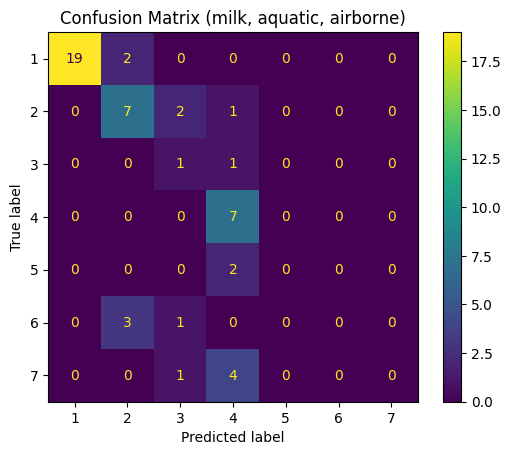

Test Accuracy (3 features): 0.6666666666666666
Classes predicted: [1 2 3 4]


,1,2,3,4,5,6,7
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Select only the three features
features_small = ["milk", "aquatic", "airborne"]
X_small = df[features_small]
y = df["class"]

# 50/50 split (stratified)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_small, y,
    test_size=0.5,
    stratify=y,
    random_state=42
)

# Scale (not strictly necessary for binary features but keeps consistency)
scaler2 = StandardScaler()
X_train2_s = scaler2.fit_transform(X_train2)
X_test2_s = scaler2.transform(X_test2)

# Use the same optimal k (k = 1 from earlier)
model2 = KNeighborsClassifier(n_neighbors=best_k)
model2.fit(X_train2_s, y_train2)

y_pred2 = model2.predict(X_test2_s)

# Confusion matrix
cm2 = confusion_matrix(y_test2, y_pred2, labels=sorted(y.unique()))

ConfusionMatrixDisplay(cm2, display_labels=sorted(y.unique())).plot()
plt.title("Confusion Matrix (milk, aquatic, airborne)")
plt.show()

print("Test Accuracy (3 features):", accuracy_score(y_test2, y_pred2))

# Check which classes are actually predicted
print("Classes predicted:", np.unique(y_pred2))

# Probabilities
probs = model2.predict_proba(X_test2_s)
probs_df = pd.DataFrame(probs, columns=model2.classes_)
probs_df.head()

**Q6.** This is a case study using $k$ nearest neighbor regression for imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to column filter the dataframe to those variables.
2. Set use `.isnull()` and `.loc` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings.
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Describe what you see.

**Q7.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and use $k$-NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a list of matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set? Report the accuracy, compute a confusion matrix, and explain your findings.
6. For your confusion matrix, which mistakes are most likely? Do you find any interesting patterns?
7. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)